In [1]:
%matplotlib inline
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_data(p, n):
    raw = np.random.uniform(-1, 1, n * p)
    raw.resize((n, p))
    return raw

In [3]:
test = generate_data(1, 100)

In [4]:
def f(x: np.ndarray):
    shape = x.shape
    if len(shape) == 1:
        tmp = [-8 * sum(x*x)]
    elif len(shape) == 2:
        tmp = np.array([-8 * sum(instance * instance) for instance in x])
    else:
        raise ValueError('Shape for X not supported')
    return np.exp(tmp)

In [5]:
def simulate(n_sim, p, n):
    res = np.ones(n_sim)
    MSE = 0
    sum_dist = 0
    for i in range(n_sim):
        sample = generate_data(p, n)
        sample_distance = np.linalg.norm(sample, ord = 2, axis = 1)
        
        nearest_idx = sample_distance.argmin()
        nearest_x = sample[nearest_idx]
        nearest_distance = sample_distance[nearest_idx]
        
        prediction = f(nearest_x)[0]
        MSE += (1-prediction)**2
        res[i] = prediction
        sum_dist += nearest_distance
        
    return {'sim_y': res, 'MSE': MSE / n_sim, 'var_sim_y': res.var(), 'sq_bias': (1-res.mean())**2, 'ave_dist': sum_dist / n_sim}

In [6]:
dims = np.arange(1, 11, 1)
data = {
    p: simulate(100, p, 100) for p in dims
}

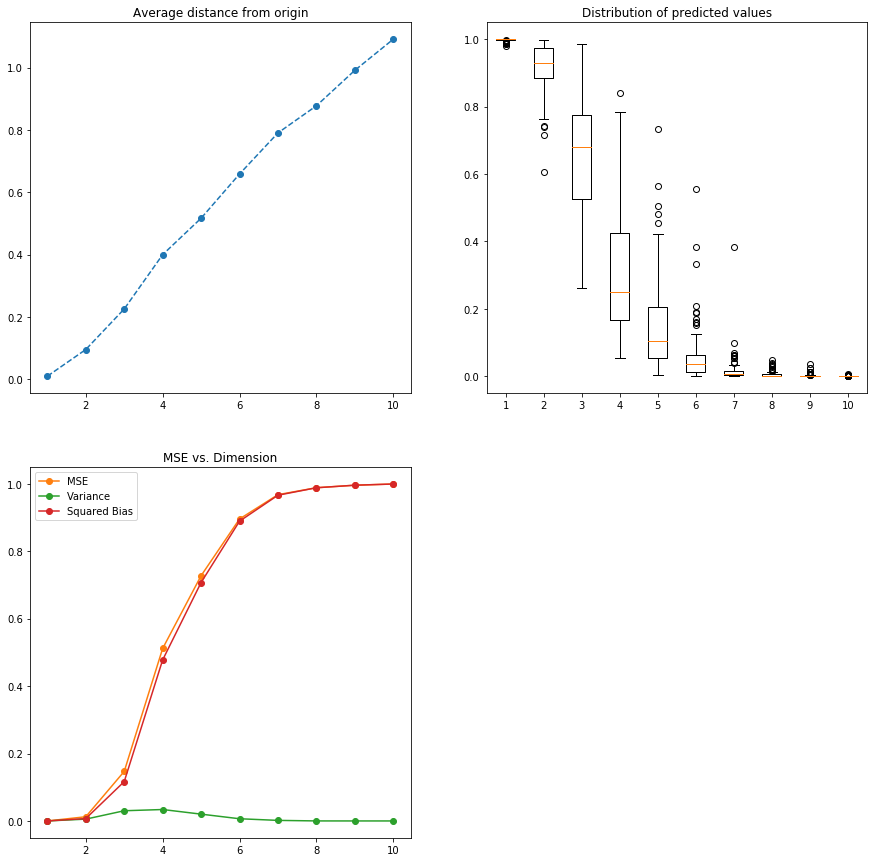

In [7]:
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(dims, [data[p]['ave_dist'] for p in dims], 'o--', color = 'C0')
ax1.set_title('Average distance from origin')

ax2 = fig.add_subplot(2, 2, 2)
ax2.boxplot([data[p]['sim_y'] for p in dims])
ax2.set_title('Distribution of predicted values')

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(dims, [data[p]['MSE'] for p in dims], 'o-', color = 'C1', label = 'MSE')
ax3.plot(dims, [data[p]['var_sim_y'] for p in dims], 'o-', color = 'C2', label = 'Variance')
ax3.plot(dims, [data[p]['sq_bias'] for p in dims], 'o-', color = 'C3', label = 'Squared Bias')
ax3.set_title('MSE vs. Dimension')
ax3.legend()
plt.show()

In [8]:
def f1(x: np.ndarray, e = None):
    shape = x.shape
    if len(shape) > 1:
        x = x[:, 0]
        x = x.flatten()
    if e is None: 
        e = np.random.randn(len(x))
    return x + e
    
def f2(x, e = None):
    shape = x.shape
    if len(shape) > 1:
        x = x[:, 0]
        x = x.flatten()
    if e is None: 
        e = np.random.randn(len(x))
    return np.power(x+1, 3) / 2 + e

In [84]:
import pdb
def simulate2(n_sim, p, n):
    final_res = {}
    for i in range(n_sim):
        sample = generate_data(p, n)
        sample_distance = np.linalg.norm(sample, ord = 2, axis = 1)
        nearest_idx = sample_distance.argmin()
        
        #pdb.set_trace()
        res = {}
        res['Linear'] = {'y0': 0 + np.random.randn(1), 'func': f1, 'y': f1(sample)}
        res['Cubic'] = {'y0': 0.5 + np.random.randn(1), 'func':f2, 'y': f2(sample)}
        #pdb.set_trace()
        for model in ['Linear', 'Cubic']:
            func = res[model]['func']
            
            # KNN method
            #
            KNN_prediction = func(sample[nearest_idx].reshape((1,p)))
            res[model]['1NN'] = (res[model]['y0'] - KNN_prediction)**2
            
            # Linear regression
            X = np.hstack((np.ones((n, 1)), sample))
            beta = np.linalg.inv(X.T @ X) @ (X.T @ res[model]['y'])
            X_0 = np.concatenate(([1], np.zeros(p)))
            LR_prediction = X_0.reshape((1, (p+1))) @ beta
            #pdb.set_trace()
            res[model]['Regression'] = (res[model]['y0'] - LR_prediction)**2
            
            # summary
        for model in ['Linear', 'Cubic']:
            if model not in final_res: final_res[model] = {}
            for method in ['1NN', 'Regression']:
                if method not in final_res[model]: final_res[model][method] = 0.0
                final_res[model][method] += res[model][method] / n_sim
        
    return final_res

In [85]:
n_sim = 10000
sample_size = 500
dims = np.arange(1, 11, 1)

In [86]:
simulate2(10000, 5, 500)

{'Cubic': {'1NN': array([2.08850069]), 'Regression': array([1.23024666])},
 'Linear': {'1NN': array([2.05249166]), 'Regression': array([0.99491662])}}

In [87]:
data = {
    p: simulate2(n_sim, p, sample_size) for p in dims
}

In [88]:
Ratios = {}
for model in ['Cubic', 'Linear']:
    Ratios[model] = [data[p][model]['1NN'] / data[p][model]['Regression'] for p in dims]
Ratios

{'Cubic': [array([1.613299]),
  array([1.58222244]),
  array([1.62422324]),
  array([1.61167636]),
  array([1.63228524]),
  array([1.68124591]),
  array([1.74708595]),
  array([1.76885004]),
  array([1.82587991]),
  array([1.84233493])],
 'Linear': [array([1.9847287]),
  array([1.97563192]),
  array([2.06106367]),
  array([1.99709312]),
  array([2.04885515]),
  array([2.03476116]),
  array([2.05596577]),
  array([2.07330547]),
  array([2.07030557]),
  array([2.13133035])]}

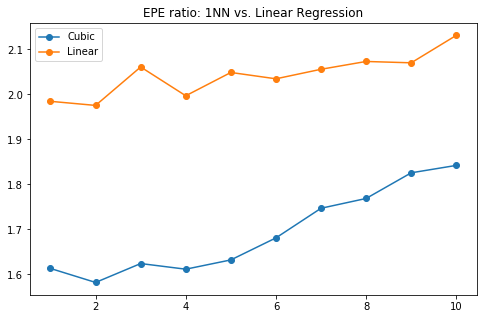

In [92]:
fig = plt.figure(figsize = (8, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(dims, Ratios['Cubic'], 'o-', color = 'C0', label = 'Cubic')
ax1.plot(dims, Ratios['Linear'], 'o-', color = 'C1', label = 'Linear')
ax1.legend()
ax1.set_title('EPE ratio: 1NN vs. Linear Regression')
plt.show()